---
# 04_featureset_importance.ipynb
---

## Introduction: What is Feature Importance Analysis?

**Feature importance analysis** helps reveal how different inputs affect model predictions.

It is useful for:

* **Interpretability** – seeing which variables drive outcomes.
* **Diagnostics** – identifying redundant or weak features that may add noise.
* **Domain insights** – revealing which physical, statistical, or operational descriptors are most relevant for the task

We focus on two main approaches:

* **Model-based**: importance derived from model internals (e.g., tree importances, coefficients).
* **Perturbation-based**: measuring prediction changes when features are shuffled or masked.

In this notebook, we’ll show how to:

* Extract statistical features from battery voltage data.
* Evaluate and visualize feature importance to understand which features contribute most.


## Step 1: Loading Example Data

We begin by downloading an example dataset from our battery health estimation paper: “Fine-tuning for rapid capacity estimation of lithium-ion batteries” ([10.1016/j.ensm.2025.104425](https://doi.org/10.1016/j.ensm.2025.104425)).
This dataset contains time-series voltage responses to 100-second DC pulses collected across the life of several lithium-ion cells.
More information on the dataset and usage can be found on the following GitHub repository: [REIL-UConn/fine-tuning-for-rapid-soh-estimation]{https://github.com/REIL-UConn/fine-tuning-for-rapid-soh-estimation.git}.


We'll download and load the data from GitHub. 
The file is a `.pkl` (pickled Python object) containing a dictionary of key-value arrays.

In [ ]:
import pickle
import urllib.request
import warnings
from pathlib import Path
import modularml as mml

DATA_URL = "https://raw.githubusercontent.com/REIL-UConn/fine-tuning-for-rapid-soh-estimation/main/processed_data/UConn-ILCC-NMC/data_slowpulse_1.pkl"
DATA_DIR = Path("downloaded_data")
DATA_PATH = DATA_DIR / "data_slowpulse_1.pkl"
DATA_DIR.mkdir(exist_ok=True, parents=True)

if not DATA_PATH.exists():
    print("Downloading data...")
    urllib.request.urlretrieve(url=DATA_URL, filename=DATA_PATH)
    print("Download complete.")
else:
    print("Data already downloaded.")

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=DeprecationWarning)
    data = pickle.load(Path.open(DATA_PATH, "rb"))

print(f"Available keys: {list(data.keys())}")
print(f"Total number of samples: {len(data[next(iter(data.keys()))])}")

Download complete.
Available keys: ['cell_id', 'group_id', 'rpt', 'num_cycles', 'soc', 'soc - coulomb', 'pulse_type', 'voltage', 'q_dchg', 'soh', 'dcir_chg_10', 'dcir_dchg_10', 'dcir_chg_20', 'dcir_dchg_20', 'dcir_chg_30', 'dcir_dchg_30', 'dcir_chg_40', 'dcir_dchg_40', 'dcir_chg_50', 'dcir_dchg_50', 'dcir_chg_60', 'dcir_dchg_60', 'dcir_chg_70', 'dcir_dchg_70', 'dcir_chg_80', 'dcir_dchg_80', 'dcir_chg_90', 'dcir_dchg_90']
Total number of samples: 24048


## Step 2: Understanding the Data Format

Our data is structured as a dictionary, where each key corresponds to a signal or property:
* `voltage`: the time-series voltage response during a 100-second pulse (shape: [n_samples, 101])
* `soh`: state-of-health, a float between ~0.5 and 1.0
* `cell_id`, `group_id`, `pulse_type`, `soc`: metadata about the sample


## Step 3: Creating a raw FeatureSet

To create a `FeatureSet`, we use the `from_dict()` constructor. 
We must assign a `label`, which uniquely identifies this `FeatureSet` within the broader modeling pipeline (e.g., when connecting to model stages).

In [4]:
from modularml.core import FeatureSet

fs_raw = FeatureSet.from_dict(
    label="PulseFeaturesRaw",
    data={
        "voltage": data["voltage"],
        "soh": data["soh"],
        "cell_id": data["cell_id"],
        "group_id": data["group_id"],
        "pulse_type": data["pulse_type"],
        "pulse_soc": data["soc"],
    },
    feature_keys="voltage",
    target_keys="soh",
    tag_keys=["cell_id", "group_id", "pulse_type", "pulse_soc"],
)
fs_raw


FeatureSet(label='PulseFeaturesRaw', n_samples=24048)

## Step 3: Derive statistical features from voltage and create a new FeatureSet

Helper function: stats on a 1D array-like

In [6]:
import numpy as np
import pandas as pd

def voltage_stats_1d(x):
    arr = np.asarray(x, dtype=float).ravel()
    arr = arr[~np.isnan(arr)]
    if arr.size == 0:
        return dict(v_min=np.nan, v_max=np.nan, v_mean=np.nan, v_var=np.nan, v_skew=np.nan, v_kurt=np.nan)
    v_min  = float(np.min(arr))
    v_max  = float(np.max(arr))
    v_mean = float(np.mean(arr))
    v_var  = float(np.var(arr, ddof=1)) if arr.size > 1 else 0.0
    try:
        from scipy.stats import skew, kurtosis
        v_skew = float(skew(arr, bias=False)) if arr.size > 2 else 0.0
        v_kurt = float(kurtosis(arr, fisher=True, bias=False)) if arr.size > 3 else 0.0
    except Exception:
        s = pd.Series(arr)
        v_skew = float(s.skew()) if arr.size > 2 else 0.0
        v_kurt = float(s.kurt()) if arr.size > 3 else 0.0
    return dict(v_min=v_min, v_max=v_max, v_mean=v_mean, v_var=v_var, v_skew=v_skew, v_kurt=v_kurt)


Grab the voltage sequences from fs_raw

In [ ]:
try:
    voltages = fs_raw.data["voltage"]       
except Exception:
    voltages = data["voltage"]                      

Compute stats row-wise

In [11]:
stats_list = [voltage_stats_1d(v) for v in voltages]
stats_df = pd.DataFrame(stats_list)

Build the stats FeatureSet for modeling

In [ ]:
base_df = pd.DataFrame({
        "soh":        data["soh"],
        "cell_id":    data["cell_id"],
        "group_id":   data["group_id"],
        "pulse_type": data["pulse_type"],
        "pulse_soc":  data["soc"],
    })
df_stats = pd.concat([base_df.reset_index(drop=True), stats_df.reset_index(drop=True)], axis=1)


def to_np_str_series(s):
    # elementwise cast guarantees each item is np.str_ 
    return np.array([np.str_(x) for x in s.values], dtype=np.str_)

feat_cols = ["v_min","v_max","v_mean","v_var","v_skew","v_kurt"]
target    = "soh"

data_dict = {
    # features
    "v_min":  df_stats["v_min"].to_numpy(),
    "v_max":  df_stats["v_max"].to_numpy(),
    "v_mean": df_stats["v_mean"].to_numpy(),
    "v_var":  df_stats["v_var"].to_numpy(),
    "v_skew": df_stats["v_skew"].to_numpy(),
    "v_kurt": df_stats["v_kurt"].to_numpy(),
    # target
    "soh":    df_stats["soh"].to_numpy(),
    # tags — force NumPy string scalars where needed
    "cell_id":    to_np_str_series(df_stats["cell_id"]),
    "group_id":   df_stats["group_id"].to_numpy(),        
    "pulse_type": to_np_str_series(df_stats["pulse_type"]),
    "pulse_soc":  df_stats["pulse_soc"].to_numpy(),
}

fs_stats = FeatureSet.from_dict(
    label="PulseFeaturesStats",
    data=data_dict,
    feature_keys=feat_cols,
    target_keys=target,
    tag_keys=["cell_id","group_id","pulse_type","pulse_soc"],
)
fs_stats

FeatureSet(label='PulseFeaturesStats', n_samples=24048)

#### Filtering charge samples

The `.filter` method takes keyword arguments, where keys can correspond to any attribute of the samples' tags, features, or targets.

In [18]:
charge_samples = fs_stats.filter(pulse_type="chg")
print(charge_samples)
print(f"Filtered to {len(charge_samples.samples)} charge-only samples.")

FeatureSet(label='filtered', n_samples=12024)
Filtered to 12024 charge-only samples.


Note that the `.filter` method returns a new `FeatureSet` containing copies of the filtered samples.

By default, it is returned with a label of `'filtered'`, but we can set a new label with `.set_label`.


In [19]:
charge_samples.label = "ChargePulseFeatures"
print(charge_samples)

FeatureSet(label='ChargePulseFeatures', n_samples=12024)


## Step 4: Running feature importance
Using both model-based (Random Forest) and perturbation-based (permutation) importance


1) Setup: imports and reproducible config

In [20]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupShuffleSplit
from sklearn.inspection import permutation_importance

RANDOM_STATE = 42
feat_cols = ["v_min","v_max","v_mean","v_var","v_skew","v_kurt"]
target_col = "soh"
group_tag  = "group_id"  


2) Build X, y, and group labels from FeatureSet

In [ ]:
def _scalar(x):
    arr = np.asarray(x).ravel()
    return float(arr[0]) if arr.size else np.nan

def arrays_from_featureset(fs, feature_keys, target_key, group_key):
    X_list, y_list, g_list = [], [], []
    for s in fs.samples:
        # build one feature row
        row = []
        bad = False
        for k in feature_keys:
            v = _scalar(s.features[k].value)
            if not np.isfinite(v):
                bad = True
                break
            row.append(v)
        if bad:
            continue

        # target
        yv = _scalar(s.targets[target_key].value)
        if not np.isfinite(yv):
            continue

        # group label 
        gv = s.tags[group_key].value
        g_list.append(gv)
        y_list.append(yv)
        X_list.append(row)

    X = np.asarray(X_list, dtype=float)
    y = np.asarray(y_list, dtype=float)
    groups = np.asarray(g_list)
    return X, y, groups

# Build arrays from the filtered FeatureSet
X, y, groups = arrays_from_featureset(charge_samples, feat_cols, target_col, group_tag)
print(X.shape, y.shape, groups.shape)


(12024, 6) (12024,) (12024,)


3) Group-aware train/test split

In [24]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE)
(train_idx, test_idx), = gss.split(X, groups=groups)

X_tr, X_te = X[train_idx], X[test_idx]
y_tr, y_te = y[train_idx], y[test_idx]

print(X_tr.shape, y_tr.shape)
print(X_te.shape, y_te.shape)



(9234, 6) (9234,)
(2790, 6) (2790,)


4) Fit baseline Random Forest regressor

In [25]:
rf = RandomForestRegressor(
    n_estimators=400,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf.fit(X_tr, y_tr)
print(f"Test R^2: {rf.score(X_te, y_te):.3f}")


Test R^2: 0.961


5) Compute feature importances (model-based + permutation)

**Model-based importance** computed from the average reduction in MSE each feature provides across all splits and trees. Larger values mean the feature is frequently used in informative splits (often near the top of trees).

In [26]:
# (a) Model-based
imp_model = rf.feature_importances_
order = np.argsort(imp_model)[::-1]
feat_order = [feat_cols[i] for i in order]
imp_model_sorted = imp_model[order]

**Permutation-based importance** measures how much test performance drops when we randomly shuffle one feature at a time (breaking its relationship to the target). The bar height is the mean drop across repeats; the error bars show variability across shuffles.

In [27]:
# (b) Permutation-based (on held-out test)
perm = permutation_importance(
    rf, X_te, y_te,
    n_repeats=20,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
imp_perm_mean = perm.importances_mean[order]
imp_perm_std  = perm.importances_std[order]

6) Plot feature importance

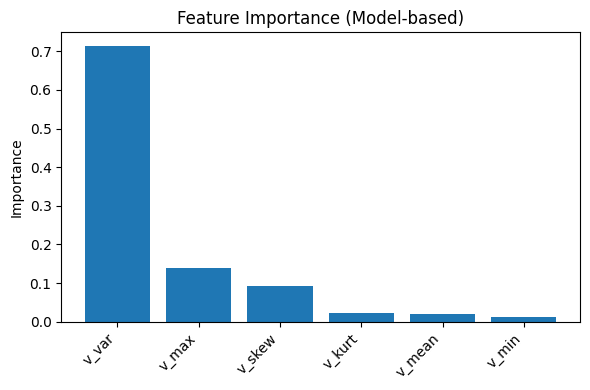

In [31]:
# Model-based 
plt.figure(figsize=(6,4))
plt.bar(range(len(feat_order)), imp_model_sorted)
plt.xticks(range(len(feat_order)), feat_order, rotation=45, ha="right")
plt.ylabel("Importance")
plt.title("Feature Importance (Model-based)")
plt.tight_layout()
plt.show()

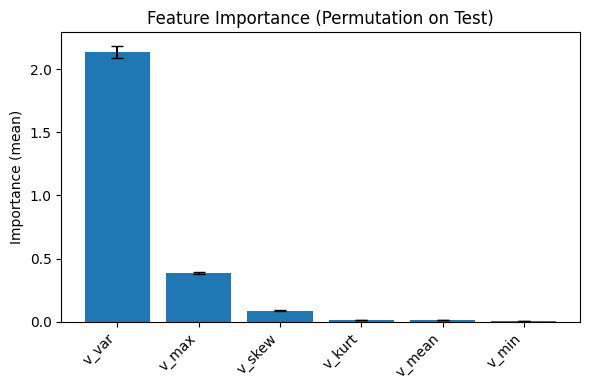

In [ ]:
# Permutation-based
plt.figure(figsize=(6,4))
x = np.arange(len(feat_order))
plt.bar(x, imp_perm_mean)
plt.errorbar(x, imp_perm_mean, yerr=imp_perm_std, fmt="none", capsize=4, ecolor="black", zorder=3)
plt.xticks(x, feat_order, rotation=45, ha="right")
plt.ylabel("Importance (mean)")
plt.title("Feature Importance (Permutation on Test)")
plt.tight_layout()
plt.show()